In [1]:
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
import numpy as np
import time

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: keras
    Found existing installation: keras 3.0.2
    Uninstalling keras-3.0.2:
      Successfully uninstalled keras-3.0.2
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.26.3 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.26.3 which is incompatible.
google-cloud-storage 1.31.0 requires google-auth<2.0dev,>=1.11.0, but you have google-auth 2.26.2 which is incom

In [2]:
w = 28
h = 28
res = w * h
rate = 0.1
hidden_layer = 300
classes = 10
epochs = 20
batch_size = 32

Загрузка набора данных MNIST и нормализация значений 

In [3]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X.reshape(-1, w * h).astype('float32') / 255
test_X = test_X.reshape(-1, w * h).astype('float32') / 255
train_y = to_categorical(train_y, classes)
test_y = to_categorical(test_y, classes)

In [4]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))
print(test_X[0])

X_train: (60000, 784)
Y_train: (60000, 10)
X_test:  (10000, 784)
Y_test:  (10000, 10)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.    

Отображение даных

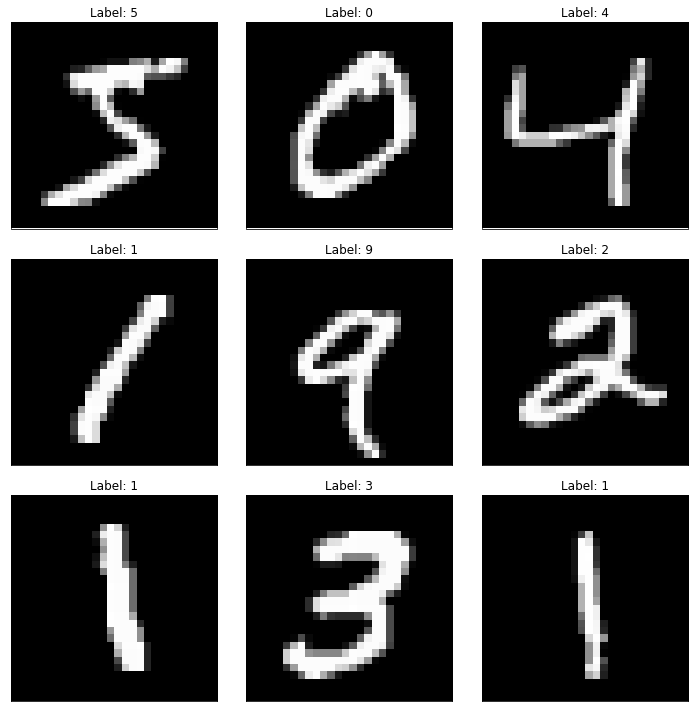

In [6]:

num_images = 9

grid_size = int(np.sqrt(num_images))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(train_X[i].reshape(w, h), cmap='gray')
    )
    ax.set_title(f"Label: {np.argmax(train_y[i])}")
    
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

Создание модели нейронной сети

In [10]:
def ReLU(x):
    """Rectified Linear Unit activation function."""
    return np.maximum(x, 0)

def softMax(x):
    """Softmax activation function."""
    ex = np.exp(x - np.max(x, axis=1, keepdims=True))  # Prevent overflow
    return ex / np.sum(ex, axis=1, keepdims=True)

class Model:
    def __init__(self, input_layer: int, hidden_layer: int, output_layer: int, learning_rate: float):
        """Initialize the neural network model."""
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.learning_rate = learning_rate
        
       
        self.input_weights = np.random.randn(input_layer, hidden_layer) * 0.01
        self.hidden_bias = np.zeros((1, hidden_layer))
        
        self.hidden_weights = np.random.randn(hidden_layer, output_layer) * 0.01
        self.output_bias = np.zeros((1, output_layer))
        
    def forward(self, x):
        """Perform forward propagation."""
        self.values_first = x.dot(self.input_weights) + self.hidden_bias
        self.values_first_ReLU = ReLU(self.values_first)
        self.values_second = self.values_first_ReLU.dot(self.hidden_weights) + self.output_bias
        self.values_second_softmax = softMax(self.values_second)
        return self.values_second_softmax

    def backward(self, x, y):
        """Perform backpropagation."""
        answer = np.eye(self.output_layer)[y]
        
        dlt2 = (self.values_second_softmax - answer) / self.values_second_softmax.shape[0]
        dReLU = np.where(self.values_first > 0, 1, 0)
        dlt1 = dlt2.dot(self.hidden_weights.T) * dReLU
        dW2 = self.values_first_ReLU.T.dot(dlt2)
        dW1 = x.T.dot(dlt1)
        
        self.hidden_weights -= self.learning_rate * dW2
        self.input_weights -= self.learning_rate * dW1
        self.hidden_bias -= self.learning_rate * np.sum(dlt1, axis=0, keepdims=True)
        self.output_bias -= self.learning_rate * np.sum(dlt2, axis=0, keepdims=True)
    
    def cross_entropy_loss(self, u, y):
        """Calculate the cross-entropy loss."""
        logits_for_answers = u[np.arange(len(u)), y]
        loss = -np.log(logits_for_answers)
        return np.mean(loss)

    def accuracy(self, predictions, labels):
        """Calculate the accuracy of the predictions."""
        return np.mean(np.argmax(predictions, axis=1) == labels)

Net = Model(res, hidden_layer, classes, rate)
times = []
for epoch in range(epochs):
    start_time = time.time()
    for batch in range(0, len(train_X), batch_size):
        images = train_X[batch:batch + batch_size]
        labels = np.argmax(train_y[batch:batch + batch_size], axis=1)  # Преобразуем one-hot в индексы
        Net.forward(images)
        Net.backward(images, labels)
    end_time = time.time()
    times.append(end_time - start_time)
    result = Net.forward(train_X)
    # Используем индексы меток для вычисления точности и потерь
    labels_idx = np.argmax(train_y, axis=1)
    print("Epoch {}, time: {:.3f}, accuracy: {:.3f}, loss : {:.3f}"
          .format(epoch, times[-1], Net.accuracy(result, labels_idx), Net.cross_entropy_loss(result, labels_idx)))

Epoch 0, time: 6.558, accuracy: 0.938, loss : 0.207
Epoch 1, time: 6.610, accuracy: 0.961, loss : 0.131
Epoch 2, time: 6.592, accuracy: 0.971, loss : 0.096
Epoch 3, time: 6.441, accuracy: 0.978, loss : 0.075
Epoch 4, time: 7.423, accuracy: 0.982, loss : 0.061
Epoch 5, time: 6.866, accuracy: 0.985, loss : 0.051
Epoch 6, time: 6.924, accuracy: 0.988, loss : 0.044
Epoch 7, time: 6.922, accuracy: 0.989, loss : 0.037
Epoch 8, time: 6.558, accuracy: 0.991, loss : 0.033
Epoch 9, time: 6.976, accuracy: 0.992, loss : 0.029
Epoch 10, time: 7.448, accuracy: 0.993, loss : 0.025
Epoch 11, time: 6.750, accuracy: 0.994, loss : 0.023
Epoch 12, time: 6.548, accuracy: 0.995, loss : 0.020
Epoch 13, time: 6.531, accuracy: 0.996, loss : 0.018
Epoch 14, time: 6.651, accuracy: 0.996, loss : 0.016
Epoch 15, time: 6.590, accuracy: 0.996, loss : 0.015
Epoch 16, time: 7.227, accuracy: 0.997, loss : 0.014
Epoch 17, time: 6.824, accuracy: 0.997, loss : 0.013
Epoch 18, time: 7.110, accuracy: 0.998, loss : 0.011
Epo